In [1]:
%matplotlib inline
import numpy as np
from gPhoton.pipeline import execute_pipeline
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from gPhoton.io.fits_utils import get_fits_data, read_wcs_from_fits
from astropy.visualization import ZScaleInterval
import os
import tqdm
import imageio.v2 as imageio
from IPython.display import Image
import astropy.wcs
from gPhoton.coadd import make_shared_wcs, project_to_shared_wcs, bin_projected_weights

Notebook summary: Exploring ideas for crossmatch; testing crossmatch accuracy and completeness a little bit. Data representation.

Pipeline steps:
1. Run photometry with extraction on NUV
2. Run photometry with extraction on FUV
3. Run photometry on FUV with NUV source positions
4. Run photometry on NUV with FUV source positions
5. Generate a merged catalog from NUV extractions
6. Generate a merged catalog from FUV extractions
7. Generate a merged catalog from all NUV / FUV detections

In [2]:
from glcat_merge_utils import *

In [3]:
eclipse = 23456
datadir = "/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/"
edir = f"e{str(eclipse).zfill(5)}"
filepaths = {}
for band in ['NUV','FUV']:
    bstr = band.lower()[0]
    match_on_fuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mof.csv"
    match_on_nuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mon.csv"
    filepaths[band] = {'mof':match_on_fuv_fn,
                         'mon':match_on_nuv_fn}
filepaths

{'NUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mon.csv'},
 'FUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mon.csv'}}

In [4]:
ra_nuv,dec_nuv,x_nuv,y_nuv = pd.read_csv(filepaths['NUV']['mon'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
ra_fuv,dec_fuv,x_fuv,y_fuv = pd.read_csv(filepaths['FUV']['mof'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
print(len(ra_nuv),len(ra_fuv))

4840 3962


In [5]:
nuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-ffull-image-r.fits'
fuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-ffull-image-r.fits'
data =  {'NUV':{'fn':nuv_image_fn,
                'count':get_fits_data(nuv_image_fn,dim=1),
                'flag':get_fits_data(nuv_image_fn,dim=2),
                'edge':get_fits_data(nuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(nuv_image_fn)[1][0],
                #'cat':pd.read_csv(filepaths['NUV']['mon'],index_col=None)[['ra','dec','xcentroid','ycentroid']],
               },
         'FUV':{'fn':fuv_image_fn,
                'count':get_fits_data(fuv_image_fn,dim=1),
                'flag':get_fits_data(fuv_image_fn,dim=2),
                'edge':get_fits_data(fuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(fuv_image_fn)[1][0],
                #'cat':pd.read_csv(filepaths['FUV']['mof'],index_col=None)[['ra','dec','xcentroid','ycentroid']],
               },
        }
for band in ['NUV','FUV']:
    bstr = band.lower()[0]
    match_on_fuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mof.csv"
    match_on_nuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mon.csv"
    data[band]['cat_mof']=pd.read_csv(match_on_fuv_fn,index_col=None)
    data[band]['cat_mon']=pd.read_csv(match_on_nuv_fn,index_col=None)
#data

In [6]:
def make_band_gif(data,fn_root,temp_dir,output_dir,
                  overwrite = True,cmap="Greys_r",fps=1,apply_mask=True):
    gif_fn = f'{output_dir}{fn_root}.gif'
    if os.path.exists(gif_fn) and not overwrite:
        return gif_fn
    
    shared_wcs = make_shared_wcs((data['NUV']['wcs'],data['FUV']['wcs']))

    for band in ['NUV','FUV']:
        frame_fn = f'{temp_dir}{fn_root}-{band}-catqa.png'
        if os.path.exists(frame_fn) and not overwrite:
            continue

        pimg = project_image_to_new_wcs(data[band]['count'],
                                        data[band]['wcs'],
                                        shared_wcs)
        #proj = project_to_shared_wcs(data[band]['fn'],shared_wcs,1,apply_mask=apply_mask)
        #pimg = bin_projected_weights(proj['x'],proj['y'],proj['weight'],proj['imsz'])
        
        plt.figure(figsize=(10,10));
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.imshow(ZScaleInterval()(pimg),cmap=cmap,origin="lower")

        x_shared,y_shared = project_pixels_to_new_wcs(data[band][f'cat_mo{band[0].lower()}']['xcentroid'].values,
                                                      data[band][f'cat_mo{band[0].lower()}']['ycentroid'].values,
                                                      data[band]['wcs'],shared_wcs)
        plt.plot(x_shared,y_shared,'y.',markersize=2)
            
        plt.savefig(frame_fn)
        plt.close()
    if os.path.exists(f'{output_dir}{fn_root}.gif') and not overwrite:
        pass
    else:
        with imageio.get_writer(gif_fn, mode='I', fps=fps, loop=0) as writer:
            for band in ['NUV','FUV']:
                frame_fn = f'{temp_dir}{fn_root}-{band}-catqa.png'
                image = imageio.imread(f'{frame_fn}')
                writer.append_data(image)
    return gif_fn

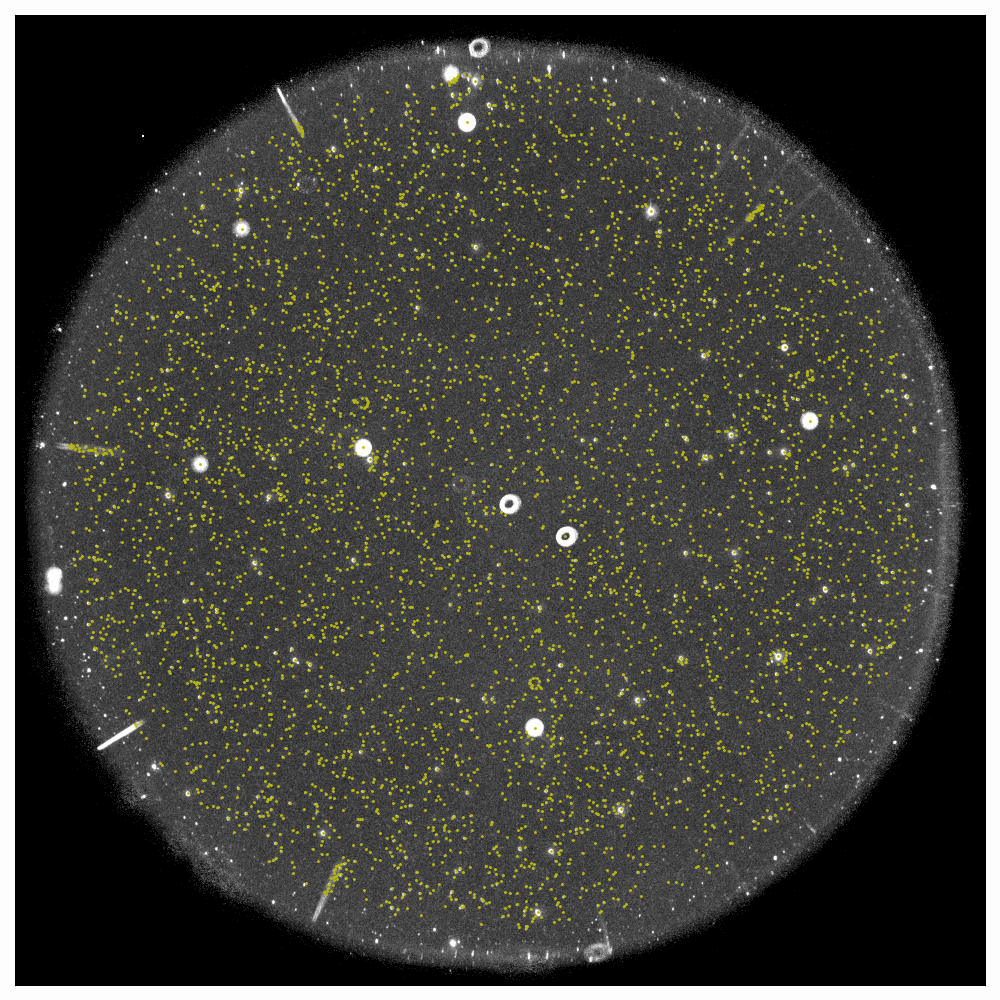

In [7]:
gif_fn = make_band_gif(data,
                  fn_root = 'e23456-fd-catqa',
                  temp_dir = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/temp/e23456/',
                  output_dir = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/',
                  overwrite = True,cmap="Greys_r",fps=1,apply_mask=False)
display(Image(data=open(gif_fn,'rb').read(), format='gif'))

In [8]:
def crossmatch_catalogs(master_table, match_table, match_radius=3*4.17e-4):
    match_catalog = SkyCoord(ra=match_table['ra'].values*u.degree,
                             dec=match_table['dec'].values*u.degree)
    master_catalog = SkyCoord(ra=master_table['ra'].values*u.degree,
                              dec=master_table['dec'].values*u.degree)
    catalog_ix, d2d, d3d = match_catalog.match_to_catalog_sky(master_catalog)
    mask = np.ones(np.array(d2d).shape)
    mask[np.where(np.array(d2d)>match_radius)] = 0
    d2d_masked = np.ma.array(d2d,mask=mask)
    catalog_ix_masked = np.ma.array(catalog_ix,mask=mask)
    return d2d_masked, catalog_ix_masked

In [9]:
match_distances, catalog_ix = crossmatch_catalogs(data['NUV']['cat_mon'],data['FUV']['cat_mof'])

In [13]:
print(3*4.17e-4)
match_distances

0.001251


masked_Angle(data=[--, 0.006736878809490208, 0.0013232703371682157, ...,
                   --, 0.003126318313376963, --],
             mask=[ True, False, False, ...,  True, False,  True],
       fill_value=1e+20)

[1403.56646514 1449.07227061] [2718.62645743 2755.98831296]


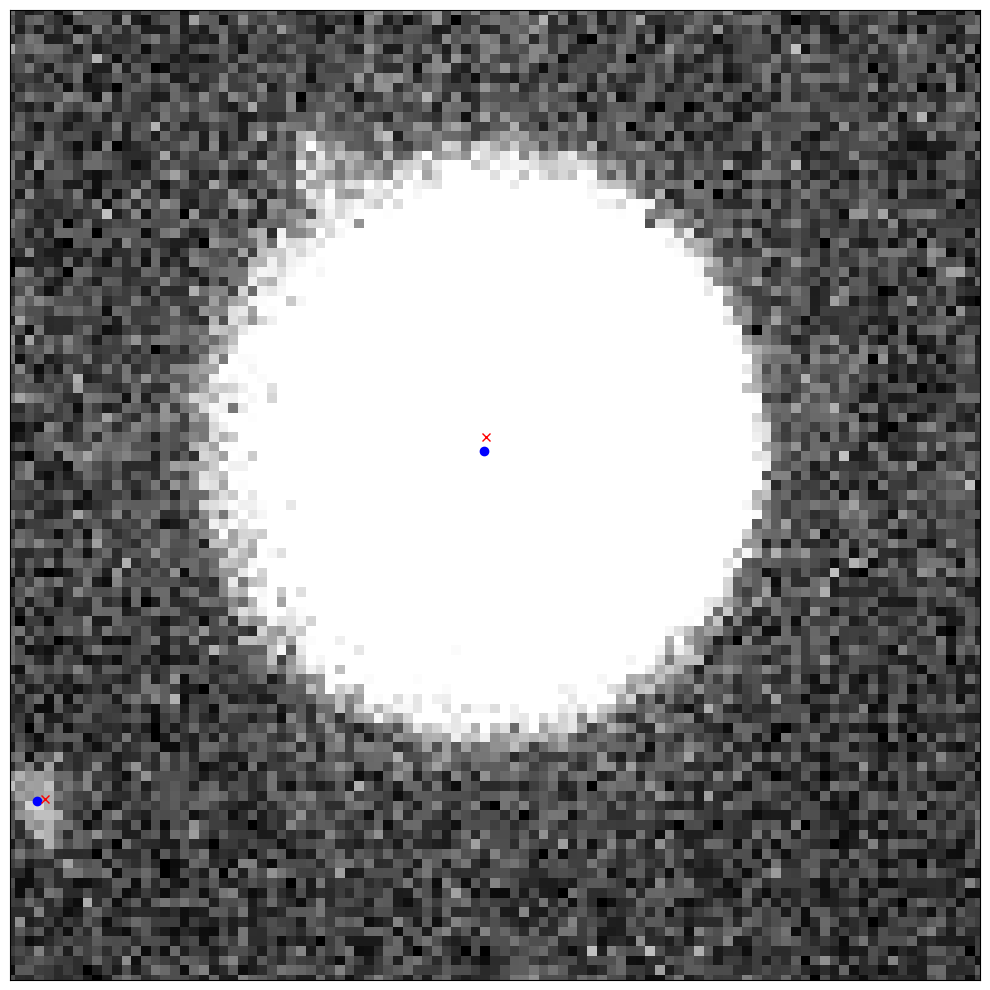

In [54]:
match_distances, catalog_ix = crossmatch_catalogs(
    data['NUV']['cat_mon'],
    data['FUV']['cat_mof'],
    match_radius = 10*4.17e-4)
shared_wcs = make_shared_wcs((data['NUV']['wcs'],data['FUV']['wcs']))

plt.figure(figsize=(10,10));
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.imshow(ZScaleInterval()(data['NUV']['count']),cmap="Greys_r",origin="lower")

x_fuv_on_nuv,y_fuv_on_nuv = project_pixels_to_new_wcs(
                                              data['FUV'][f'cat_mof']['xcentroid'].values,
                                              data['FUV'][f'cat_mof']['ycentroid'].values,
                                              data['FUV']['wcs'],data['NUV']['wcs'])

plt.plot(data['NUV'][f'cat_mon']['xcentroid'].values[catalog_ix],
         data['NUV'][f'cat_mon']['ycentroid'].values[catalog_ix],'bo')
plt.plot(x_fuv_on_nuv,
         y_fuv_on_nuv,'rx')
plt.xlim([1400,1500])
plt.ylim([2700,2800])
ix = np.where((x_fuv_on_nuv>1400) & (x_fuv_on_nuv<1500) &
              (y_fuv_on_nuv>2700) & (y_fuv_on_nuv<2800))
print(x_fuv_on_nuv[ix],
      y_fuv_on_nuv[ix])

In [52]:
np.unique(catalog_ix)

masked_array(data=[4, 43, 56, 85, 106, 116, 131, 152, 163, 176, 216, 219,
                   222, 225, 241, 245, 268, 280, 296, 297, 299, 338, 343,
                   380, 381, 406, 415, 462, 496, 500, 501, 503, 537, 542,
                   561, 584, 587, 595, 598, 613, 621, 622, 636, 682, 699,
                   723, 733, 742, 752, 759, 770, 776, 784, 788, 790, 791,
                   816, 822, 828, 849, 854, 874, 880, 886, 894, 896, 926,
                   927, 949, 953, 960, 962, 970, 971, 979, 982, 990, 1028,
                   1029, 1034, 1040, 1043, 1062, 1063, 1071, 1072, 1074,
                   1081, 1087, 1091, 1099, 1105, 1118, 1128, 1137, 1145,
                   1149, 1153, 1161, 1184, 1191, 1194, 1200, 1212, 1224,
                   1233, 1243, 1259, 1260, 1265, 1266, 1277, 1280, 1282,
                   1286, 1287, 1305, 1306, 1313, 1322, 1332, 1363, 1365,
                   1370, 1381, 1384, 1402, 1411, 1412, 1423, 1440, 1441,
                   1456, 1498, 1512, 1524, 

In [45]:
len(catalog_ix)

3962

In [50]:
data['FUV']['cat_mof'][catalog_ix]

KeyError: "None of [Index([   3,    4,   10,   14,   13,   43,   22,   23,   29,   32,\n       ...\n       4544, 4544, 4826, 4561, 4826, 4826, 4590, 4590, 4627, 4627],\n      dtype='int64', length=3962)] are in the [columns]"

In [48]:
len(np.unique(catalog_ix))

571